In [2]:
! git clone https://github.com/RoboticsClubatUCF/CV-Workshop

Cloning into 'CV-Workshop'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 28 (delta 4), reused 17 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


# ***Hello!***
This repository was created by Dylan Hall in the attendance of a workshop with the UCF Robotics Club. This repository combines this workshops presentation by club president Marc Simmonds as well as lectures from EEL4660, Robotic Systems, with Professor Mike Borowczak.


In [3]:
# Library imports
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow

##Introduction and Pre-Processing
  After importing all of the libraries being used, I am uploading the image to be read, and preparing it to be processed. To do this, we are reducing noice with a gaussian blur. This blur scans through each pixel of the image, and changes its color by taking an average of the pixels surrounding it, with a special case at borders.

  Our end goal of this processing is to be able to detect the white of 
the lane lines on the road in this image, so to do that, we are converting the image to greyscale, and posterizing it down to 2 colors: white and black.

In [4]:
# Image pre-processing

picPath = os.path.join("CV-Workshop","Pictures", "test_img2.jpg")
origImg = cv2.imread(picPath, cv2.IMREAD_UNCHANGED)
    # Clean up the noise
img = cv2.GaussianBlur(origImg, (5,5), cv2.BORDER_DEFAULT)
    # Now convert to greyscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Now apply an image threshold to saturate it, posterize it to more easily detect white and black
cv2.threshold(img, 150, 255, type=cv2.THRESH_BINARY, dst=img)


(150.0, array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

We don't need to use the entire image. In fact, that bright blue sky, as well as white liscense plates and white cars, would be a distraction. To crop these out, we literally crop them out, transforming and warping the image's perspective to focus and detect on just the road ahead.

In [5]:
# Perspective transform

height, width = img.shape

    # Input points: top left, bottom left, bottom right, top right
A1 = [int(width*.45),int(height*.6)]
B1 = [int(width*.2),int(height*.95)]
C1 = [int(width*.8),int(height*.92)]
D1 = [int(width*.55),int(height*.6)]

inpts = [A1,B1,C1,D1]

A2 = [0,0]
B2 = [0, height-1]
C2 = [width-1, height-1]
D2 = [width-1, 0]

outpts = [A2,B2,C2,D2]

inpts = np.float32(inpts)
outpts = np.float32(outpts)

matrix = cv2.getPerspectiveTransform(inpts, outpts)

warp = cv2.warpPerspective(img, matrix, (width,height))

Here, we're using an open CV function cv2.Canny to scan this warped image, and show us our edges. There's various methods we could use for edge detection, but this one is simple, and works for what we need.

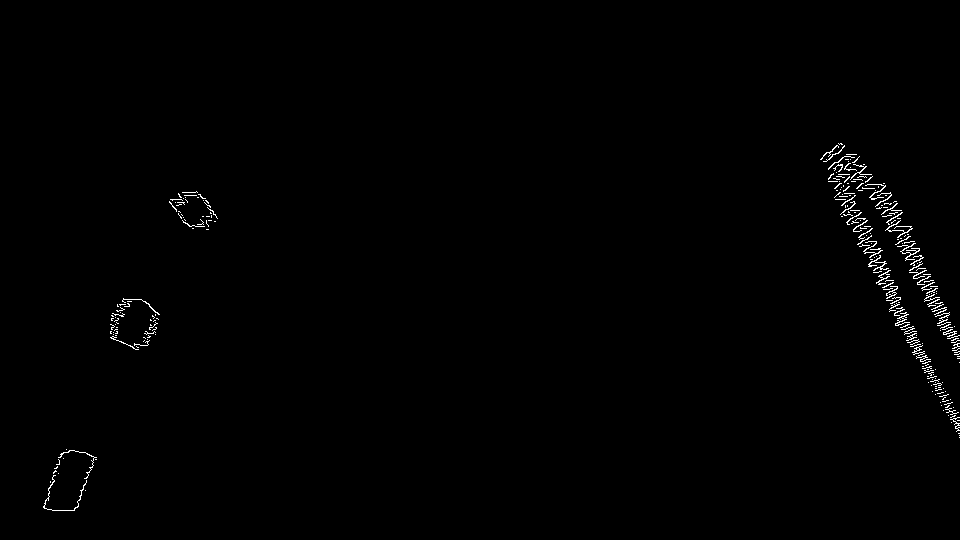

In [6]:
edges = cv2.Canny(warp, 100,100)
cv2_imshow(edges)

##Now that we have our edges...
We can turn them into a filter, and overlay it onto the actual image. This is just for us to visualize it, all of the information that a robotic system would need has been processed.

In [7]:
# Clean up the lanes, then convert them back to color
invTrans = np.linalg.pinv(matrix)

lanes = cv2.warpPerspective(warp,invTrans, (width,height))

lanes = cv2.cvtColor(lanes, cv2.COLOR_GRAY2BGR)

whiteHi = np.array([255,255,255])
whiteLow = np.array([25,25,25])

mask = cv2.inRange(lanes, whiteLow, whiteHi)

lanes[mask>0] = (0,255,0)

laneDetect = cv2.addWeighted(origImg,0.6,lanes,0.4,0)

All of the previous code identified the lanes by sorting out the white pixels of lane lines. However, we haven't used any machine trained computer vision yet. Not the cool stuff, anyways. That's all done in the following line: cv2.CascadeClassifier.detectMultiScale(), and *voila*, we can detect cars.

In [8]:
carCascade = cv2.CascadeClassifier()
paramPath = os.path.join("CV-Workshop","cascadeParams","cars.xml")
carCascade.load(paramPath)

cars = carCascade.detectMultiScale(origImg)

for (x,y,w,h) in cars:
  cv2.rectangle(laneDetect, (x,y), ((x+w),(y+h)),(0,0,255))

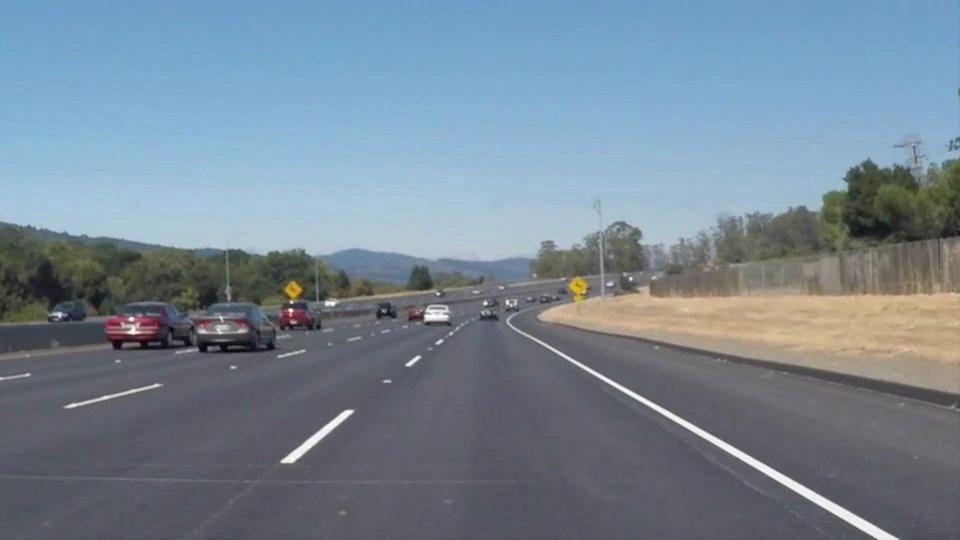

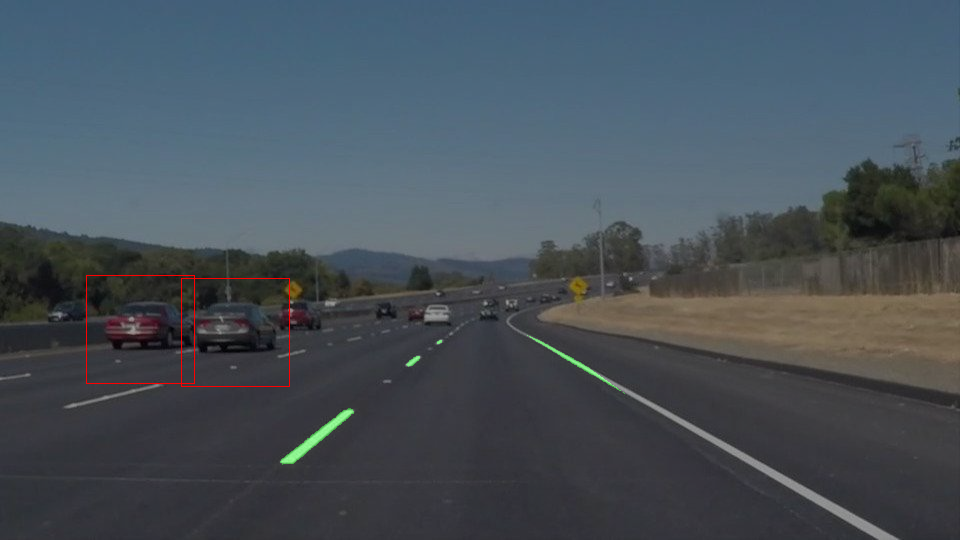

In [9]:
cv2_imshow(origImg)
cv2_imshow(laneDetect)